<a href="https://colab.research.google.com/github/businsweetie/deep_learning/blob/main/Task_1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек и функции

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras import layers

from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
def plot_training_curves(history):
  loss_values = history.history['loss'] # ошибка на тренировочном наборе
  val_loss_values = history.history['val_loss'] # ошибка на валидационном наборе
  mae_values = history.history['mae']  # точность на тренировочном наборе
  val_mae_values = history.history['val_mae'] # точность на валидационном наборе

  epochs_x = range(1, len(loss_values) + 1) # количество эпох обучения

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  # график значения функции потерь на каждой эпохе
  ax1.plot(epochs_x, loss_values, 'b', label='Ошибка обучения')
  ax1.plot(epochs_x, val_loss_values, 'r', label='Ошибка валидации')
  ax1.set_title('Ошибка при обучении и валидации', fontsize=14, fontweight="bold")
  ax1.set_xlabel('Эпохи', fontsize=12)
  ax1.set_ylabel('Значение ошибки', fontsize=12)
  ax1.grid()
  ax1.legend()

  # график значения точности на каждой эпохе
  ax2.plot(epochs_x, mae_values, 'b', label='MAE обучения')
  ax2.plot(epochs_x, val_mae_values, 'r', label='MAE валидации')
  ax2.set_title('Точность при обучении и валидации', fontsize=14, fontweight="bold")
  ax2.set_xlabel('Эпохи', fontsize=12)
  ax2.set_ylabel('Значение точности', fontsize=12)
  ax2.grid()
  ax2.legend()

  return

# Функция для подсчета метрик модели классификации
def generate_preformance_scores(y_true, y_pred):

  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  print(f'mse:\t{mse:.4f}')
  print(f'mae:\t{mae:.4f}')
  print(f'r2:\t{r2:.4f}')

  return

def scatter_plot(y_test, y_pred):
  y_pred_list = []
  for i in range(len(y_pred)):
    y_pred_list.append(y_pred[i][0])

  sns.set_style("whitegrid")
  fig, ax = plt.subplots(figsize=(5, 3))
  ax = sns.scatterplot(x=y_test, y=y_pred_list, alpha=0.5)
  ax = sns.lineplot(x=[0, max(y_test)], y=[0, max(y_test)], color='black')
  ax.set_xlim(0, max(y_test))
  ax.set_ylim(0, max(y_test))
  ax.set_title('График соответсвия истинных значений предсказанным', fontsize=12, fontweight='bold')
  ax.set_xlabel('Истинные значения', fontsize=12)
  ax.set_ylabel('Предсказанные значения', fontsize=12)

# Чтение данных

In [31]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL/DS_2019_public.csv', encoding="cp1252", encoding_errors='replace') # читаем данные в перменную df
df.head() # выводим первые 5 строк

<ipython-input-31-e4b11ac2c188>:1: DtypeWarning: Columns (30,56,96,114) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL/DS_2019_public.csv', encoding="cp1252", encoding_errors='replace') # читаем данные в перменную df


,Climate_Region_Pub,DIVISION,REPORTABLE_DOMAIN,DOLELCOL,TOTALDOLCOL,KWHCOL,BTUELCOL,TOTALBTUCOL,TOTALDOLSPH,TOTALBTUSPH,...,LGT1EE,TOTALBTUWTH,ROOFTYPE,DOLELRFG,TOTALDOLRFG,HEATROOM,WDWATER,UGWARM,DRYRFUEL,KWHRFG
0,5,10,26,16.793,17,181.998,620.979,621,368,38606,...,-2,30110,2,120.893,121,4,0,1,1,1310.220
1,1,1,1,48.901,49,184.459,629.389,629,582,40248,...,2,7933,-2,242.746,243,2,0,1,-2,915.664
2,1,3,7,101.048,101,1063.022,3627.013,3627,425,40196,...,-2,6440,5,158.797,159,7,0,1,5,1670.534
3,1,1,1,0,0,0.000,0.000,0,616,36136,...,2,13884,5,85.138,85,5,0,1,5,346.468
4,1,4,10,45.132,45,274.530,936.677,937,685,74100,...,3,14204,6,151.319,151,6,0,1,5,920.454


In [32]:
df.shape

(10875, 121)

# Исследование данных

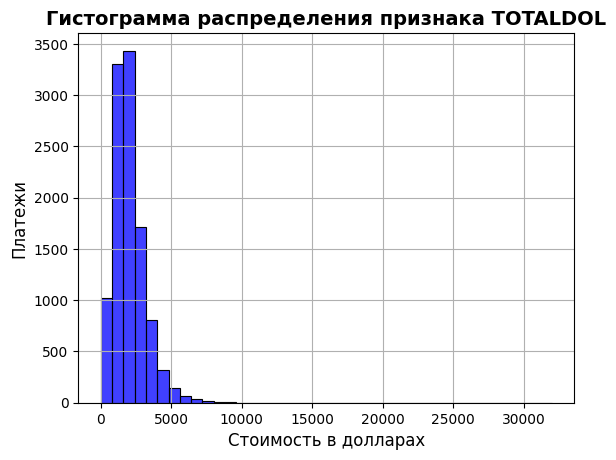

In [33]:
# seaborn histogram
sns.histplot(df["TOTALDOL"], bins=40, color='blue')
# Add labels
plt.title('Гистограмма распределения признака TOTALDOL', fontsize=14, fontweight="bold")
plt.xlabel('Стоимость в долларах', fontsize=12)
plt.ylabel('Платежи', fontsize=12)
plt.grid()

In [34]:
df["TOTALDOL"].describe()

count    10875.000000
mean      2040.286437
std       1184.555321
min          6.000000
25%       1273.000000
50%       1831.000000
75%       2543.500000
max      32012.000000
Name: TOTALDOL, dtype: float64

In [35]:
corr = df.corr()
th=0.6

corr_th = corr["TOTALDOL"][abs(corr["TOTALDOL"]) > th]
corr_th

<ipython-input-35-9782acb222e4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


TOTALDOLSPH    0.613712
DOLLAREL       0.800972
DOLELOTH       0.849037
TOTALDOLOTH    0.876769
TOTALDOL       1.000000
TOTALBTU       0.800261
TOTALBTUOTH    0.735435
TOTALDOLWTH    0.615648
BTUELOTH       0.715749
KWH            0.628529
BTUEL          0.628529
TOTALDOLRFG    0.641587
Name: TOTALDOL, dtype: float64

In [36]:
layout_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL/public_layout.csv', sep=',')

In [37]:
# create the variable names and variable descriptions in two separate lists: from dataColumns
labels = list(layout_data['Variable Label'])
places = list(layout_data['Variable Name'])

# Creating a function to find the variable definition of any variable
def whatIs(place):
    pl = places.index(place)
    print(place, ' is ', labels[pl])

In [38]:
corr_th.name

'TOTALDOL'

In [39]:
df = df.drop(corr["TOTALDOL"][abs(corr["TOTALDOL"]) <= th].keys(), axis=1)
df.head()

,DOLELCOL,TOTALDOLSPH,DOLLAREL,DOLELOTH,TOTALDOLOTH,DOLFOSPH,TOTALDOL,DOLELSPH,DOLNGWTH,TOTALBTU,TOTALBTUOTH,CUFEETNGOTH,KWHOTH,TOTALDOLWTH,BTUELOTH,KWH,BTUEL,CUFEETNGWTH,DOLELRFG,TOTALDOLRFG
0,16.793,368,475,337.315,501,0.0,1293,0,286.745,103460,29653,167.601,3655.782,287,12473.544,5148,17565,293.756,120.893,121
1,48.901,582,588,296.353,339,0.0,1327,0,114.618,58716,6781,28.944,1117.878,115,3814.291,2218,7568,77.394,242.746,243
2,101.048,425,952,512.731,534,0.0,1398,0,0.0,76401,20438,19.848,5393.913,179,18403.933,10015,34171,0,158.797,159
3,0,616,705,619.862,620,0.0,1558,0,236.762,59809,8607,0,2522.532,237,8606.856,2869,9789,135.451,85.138,85
4,45.132,685,1050,853.549,893,0.0,1906,0,131.362,114350,21968,41.498,5192.016,131,17714.799,6387,21792,138.574,151.319,151


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10875 entries, 0 to 10874
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DOLELCOL     10875 non-null  object 
 1   TOTALDOLSPH  10875 non-null  int64  
 2   DOLLAREL     10875 non-null  int64  
 3   DOLELOTH     10875 non-null  float64
 4   TOTALDOLOTH  10875 non-null  int64  
 5   DOLFOSPH     10875 non-null  object 
 6   TOTALDOL     10875 non-null  int64  
 7   DOLELSPH     10875 non-null  object 
 8   DOLNGWTH     10875 non-null  object 
 9   TOTALBTU     10875 non-null  int64  
 10  TOTALBTUOTH  10875 non-null  int64  
 11  CUFEETNGOTH  10875 non-null  object 
 12  KWHOTH       10875 non-null  object 
 13  TOTALDOLWTH  10875 non-null  int64  
 14  BTUELOTH     10875 non-null  float64
 15  KWH          10875 non-null  int64  
 16  BTUEL        10875 non-null  int64  
 17  CUFEETNGWTH  10875 non-null  object 
 18  DOLELRFG     10875 non-null  object 
 19  TOTA

In [41]:
df = df.drop(["DOLELCOL", "DOLFOSPH", "DOLELSPH", "DOLNGWTH", "CUFEETNGOTH", "KWHOTH", "CUFEETNGWTH", "CUFEETNGWTH", "DOLELRFG"], axis=1)

In [42]:
df.shape

(10875, 12)

In [43]:
for col in df.columns.values:
  whatIs(col)

TOTALDOLSPH  is  Total cost for space heating, in whole dollars, 2009
DOLLAREL  is  Total Electricity cost, in whole dollars, 2009
DOLELOTH  is  Electricity cost for other purposes (all end-uses except SPH, COL, WTH, and RFG), in wholedollars, 2009
TOTALDOLOTH  is  Total cost for appliances, electronics, lighting, and miscellaneous uses, in whole dollars, 2009
TOTALDOL  is  Total cost, in whole dollars, 2009
TOTALBTU  is  Total usage, in thousand BTU, 2009
TOTALBTUOTH  is  Total usage for appliances, electronics, lighting, and miscellaneous uses, in thousand BTU, 2009
TOTALDOLWTH  is  Total cost for water heating, in whole dollars, 2009
BTUELOTH  is  Electricity usage for other purposes (all end-uses except SPH, COL, WTH, and RFG), in thousand BTU, 2009
KWH  is  Total Site Electricity usage, in kilowatt-hours, 2009
BTUEL  is  Total Site Electricity usage, in thousand BTU, 2009
TOTALDOLRFG  is  Total cost for refrigerators, in whole dollars, 2009


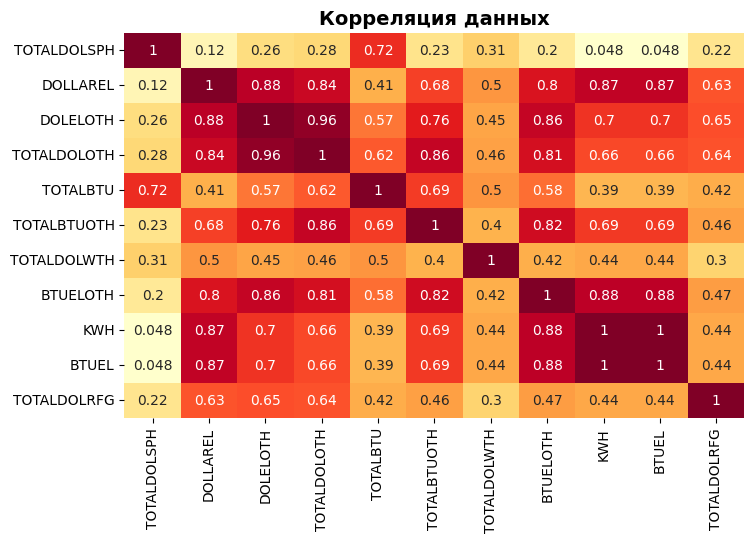

In [44]:
plt.figure(figsize = (8, 5))
sns.heatmap(df.drop("TOTALDOL", axis=1).corr(), annot=True, cmap ='YlOrRd', cbar=False)
plt.title("Корреляция данных", fontsize=14, fontweight="bold");

# Деление на выборки

In [45]:
# делим выборку на тренировочную и тестовую
X = df.drop(['TOTALDOL'],axis=1).values # удаляем целевую переменную из общего набора данных
y = df['TOTALDOL'].values # создаем отделтнуб переменную для целевого признака
X_all_train, X_test, y_all_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0) # делим набор данных на тренировочный и тестовый в соотношениии 80/20 (train/test)
X_train, X_val, y_train, y_val = train_test_split(X_all_train, y_all_train, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и валидационный в соотношениии 80/20 (train/test)

In [46]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")

Размер тренировочной выборки: (7829, 11)
Размер тестовой выборки: (1088, 11)
Размер валидационной выборки: (1958, 11)


In [17]:
# проводим стандартизацию данных, для лучшей работы нейронной сети
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Создание модели

In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

callbacks_list=[early_stop]

## Модель 1

In [19]:
model1 = keras.Sequential([
    layers.Dense(12, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1)
])

In [20]:
# компиляция модели
model1.compile(optimizer="adam",
              loss="mse",
              metrics=["mae"])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                144       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 289 (1.13 KB)
Trainable params: 289 (1.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [21]:
history1 = model1.fit(X_train,
                      y_train,
                      epochs=150,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/150
245/245 [==============================] - 4s 9ms/step - loss: 5576118.5000 - mae: 2036.1902 - val_loss: 5394841.0000 - val_mae: 2022.4523
Epoch 2/150
245/245 [==============================] - 2s 8ms/step - loss: 4985177.5000 - mae: 1900.5618 - val_loss: 3925787.7500 - val_mae: 1689.7054
Epoch 3/150
245/245 [==============================] - 2s 6ms/step - loss: 2350700.2500 - mae: 1291.4344 - val_loss: 1247010.3750 - val_mae: 975.8454
Epoch 4/150
245/245 [==============================] - 1s 4ms/step - loss: 943873.5625 - mae: 833.0571 - val_loss: 868396.4375 - val_mae: 767.5521
Epoch 5/150
245/245 [==============================] - 1s 5ms/step - loss: 725474.0000 - mae: 703.6041 - val_loss: 691916.3125 - val_mae: 680.1726
Epoch 6/150
245/245 [==============================] - 1s 5ms/step - loss: 573978.0000 - mae: 618.3925 - val_loss: 544197.6250 - val_mae: 601.2579
Epoch 7/150
245/245 [==============================] - 2s 7ms/step - loss: 438245.6562 - mae: 534.2745 - va

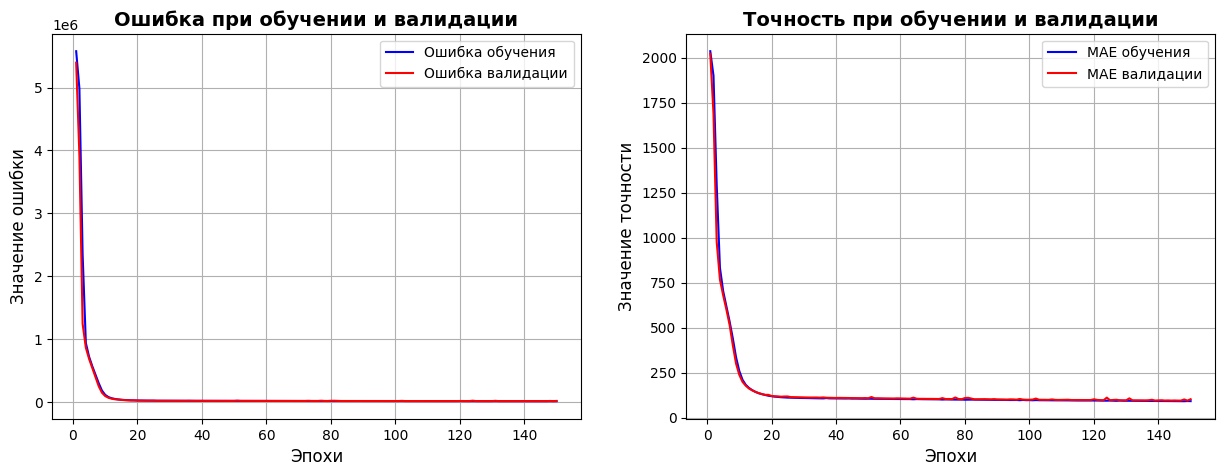

In [22]:
plot_training_curves(history1)

In [23]:
y_pred = model1.predict(X_test) # обучения модели на тестовом наборе

34/34 [==============================] - 0s 1ms/step


In [24]:
generate_preformance_scores(y_test, y_pred)

mse:	20199.7219
mae:	100.3085
r2:	0.9851


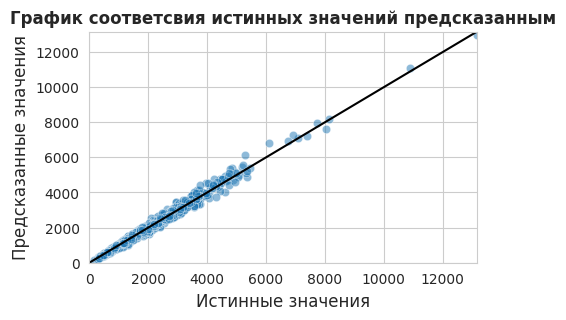

In [25]:
scatter_plot(y_test, y_pred)

## Модель 2

In [26]:
model2 = keras.Sequential([
    layers.Dense(12, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(1)
])

In [27]:
# компиляция модели
model2.compile(optimizer="adam",
              loss="mse",
              metrics=["mae"])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 12)                144       
                                                                 
 dense_5 (Dense)             (None, 1)                 13        
                                                                 
Total params: 157 (628.00 Byte)
Trainable params: 157 (628.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [28]:
history2 = model2.fit(X_train,
                      y_train,
                      epochs=150,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/150
245/245 [==============================] - 2s 4ms/step - loss: 5575598.5000 - mae: 2036.3695 - val_loss: 5446069.0000 - val_mae: 2034.6519
Epoch 2/150
245/245 [==============================] - 2s 7ms/step - loss: 5523115.0000 - mae: 2027.2516 - val_loss: 5375575.0000 - val_mae: 2022.3434
Epoch 3/150
245/245 [==============================] - 1s 3ms/step - loss: 5425229.5000 - mae: 2010.9639 - val_loss: 5256227.0000 - val_mae: 2001.8229
Epoch 4/150
245/245 [==============================] - 1s 2ms/step - loss: 5288773.0000 - mae: 1987.2188 - val_loss: 5112818.0000 - val_mae: 1976.0959
Epoch 5/150
245/245 [==============================] - 1s 2ms/step - loss: 5125928.5000 - mae: 1958.1838 - val_loss: 4940936.5000 - val_mae: 1944.6726
Epoch 6/150
245/245 [==============================] - 1s 2ms/step - loss: 4932653.0000 - mae: 1923.5950 - val_loss: 4741690.0000 - val_mae: 1907.5724
Epoch 7/150
245/245 [==============================] - 1s 2ms/step - loss: 4715476.5000 - mae:

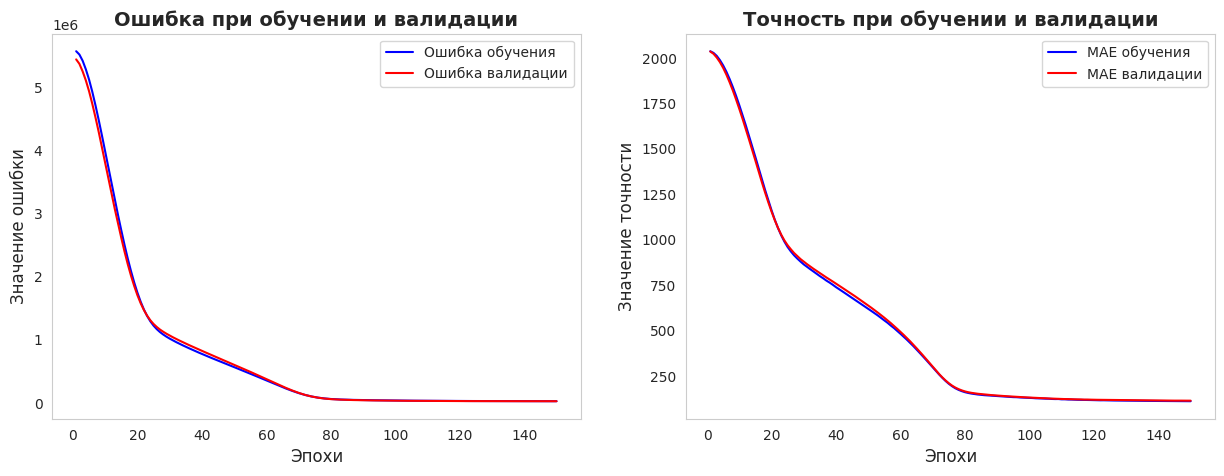

In [29]:
plot_training_curves(history2)

In [30]:
y_pred = model2.predict(X_test) # обучения модели на тестовом наборе

34/34 [==============================] - 0s 1ms/step


In [31]:
generate_preformance_scores(y_test, y_pred)

mse:	24267.5850
mae:	111.4204
r2:	0.9822


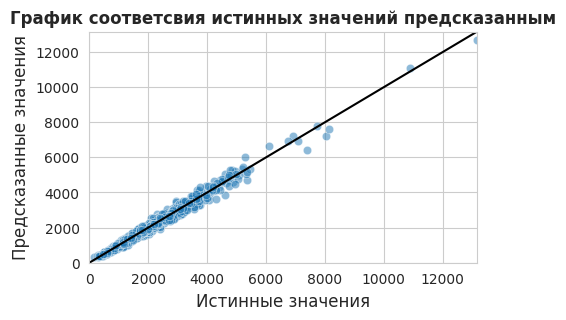

In [32]:
scatter_plot(y_test, y_pred)

# Другие признаки

In [47]:
corr = df.corr()
th=0.8

corr_th = corr["TOTALDOL"][abs(corr["TOTALDOL"]) > th]
corr_th

DOLLAREL       0.800972
DOLELOTH       0.849037
TOTALDOLOTH    0.876769
TOTALDOL       1.000000
TOTALBTU       0.800261
Name: TOTALDOL, dtype: float64

In [48]:
df = df.drop(corr["TOTALDOL"][abs(corr["TOTALDOL"]) <= th].keys(), axis=1)
df.head()

,DOLLAREL,DOLELOTH,TOTALDOLOTH,TOTALDOL,TOTALBTU
0,475,337.315,501,1293,103460
1,588,296.353,339,1327,58716
2,952,512.731,534,1398,76401
3,705,619.862,620,1558,59809
4,1050,853.549,893,1906,114350


# Деление на выборки

In [49]:
# делим выборку на тренировочную и тестовую
X = df.drop(['TOTALDOL'],axis=1).values # удаляем целевую переменную из общего набора данных
y = df['TOTALDOL'].values # создаем отделтнуб переменную для целевого признака
X_all_train, X_test, y_all_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0) # делим набор данных на тренировочный и тестовый в соотношениии 80/20 (train/test)
X_train, X_val, y_train, y_val = train_test_split(X_all_train, y_all_train, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и валидационный в соотношениии 80/20 (train/test)

In [50]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")

Размер тренировочной выборки: (7829, 4)
Размер тестовой выборки: (1088, 4)
Размер валидационной выборки: (1958, 4)


In [51]:
# проводим стандартизацию данных, для лучшей работы нейронной сети
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Создание модели

In [52]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

callbacks_list=[early_stop]

## Модель 1

In [39]:
model1 = keras.Sequential([
    layers.Dense(12, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1)
])

In [40]:
# компиляция модели
model1.compile(optimizer="adam",
              loss="mse",
              metrics=["mae"])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 12)                60        
                                                                 
 dense_7 (Dense)             (None, 8)                 104       
                                                                 
 dense_8 (Dense)             (None, 4)                 36        
                                                                 
 dense_9 (Dense)             (None, 1)                 5         
                                                                 
Total params: 205 (820.00 Byte)
Trainable params: 205 (820.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [41]:
history1 = model1.fit(X_train,
                      y_train,
                      epochs=150,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/150
245/245 [==============================] - 2s 3ms/step - loss: 5566621.0000 - mae: 2035.0293 - val_loss: 5381010.5000 - val_mae: 2021.9733
Epoch 2/150
245/245 [==============================] - 1s 2ms/step - loss: 5084651.5000 - mae: 1929.7415 - val_loss: 4139165.5000 - val_mae: 1739.6848
Epoch 3/150
245/245 [==============================] - 1s 2ms/step - loss: 2512569.2500 - mae: 1325.1296 - val_loss: 1106488.2500 - val_mae: 911.0861
Epoch 4/150
245/245 [==============================] - 1s 2ms/step - loss: 720504.5000 - mae: 698.9825 - val_loss: 540028.3750 - val_mae: 597.0362
Epoch 5/150
245/245 [==============================] - 1s 2ms/step - loss: 443321.0625 - mae: 519.4528 - val_loss: 357593.3125 - val_mae: 454.6260
Epoch 6/150
245/245 [==============================] - 1s 2ms/step - loss: 300889.0000 - mae: 408.4203 - val_loss: 242355.9531 - val_mae: 367.6823
Epoch 7/150
245/245 [==============================] - 1s 2ms/step - loss: 213758.1562 - mae: 339.9234 - va

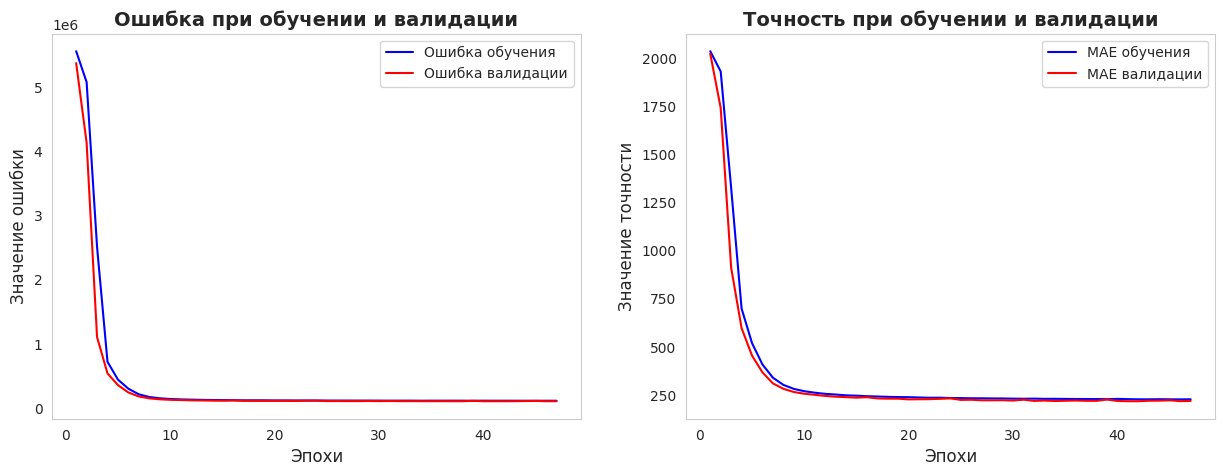

In [42]:
plot_training_curves(history1)

In [43]:
y_pred = model1.predict(X_test) # обучения модели на тестовом наборе

34/34 [==============================] - 0s 1ms/step


In [44]:
generate_preformance_scores(y_test, y_pred)

mse:	112807.9954
mae:	225.7616
r2:	0.9170


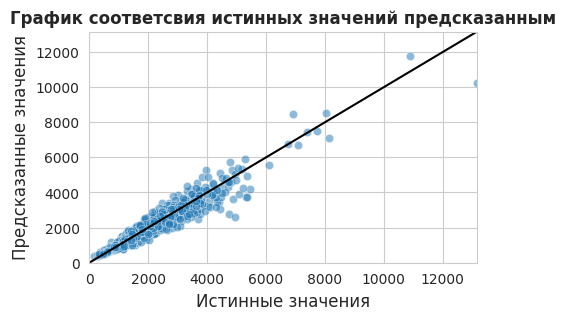

In [45]:
scatter_plot(y_test, y_pred)

## Модель 2

In [53]:
model2 = keras.Sequential([
    layers.Dense(12, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(1)
])

In [54]:
# компиляция модели
model2.compile(optimizer="adam",
              loss="mse",
              metrics=["mae"])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                60        
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 73 (292.00 Byte)
Trainable params: 73 (292.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [55]:
history2 = model2.fit(X_train,
                      y_train,
                      epochs=150,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/150
245/245 [==============================] - 2s 5ms/step - loss: 5584620.5000 - mae: 2038.4486 - val_loss: 5466443.5000 - val_mae: 2038.6682
Epoch 2/150
245/245 [==============================] - 1s 3ms/step - loss: 5564494.5000 - mae: 2034.6910 - val_loss: 5438940.5000 - val_mae: 2033.2917
Epoch 3/150
245/245 [==============================] - 1s 3ms/step - loss: 5524046.0000 - mae: 2027.0536 - val_loss: 5388338.5000 - val_mae: 2023.4678
Epoch 4/150
245/245 [==============================] - 1s 3ms/step - loss: 5463385.0000 - mae: 2015.4849 - val_loss: 5321726.5000 - val_mae: 2010.3557
Epoch 5/150
245/245 [==============================] - 1s 3ms/step - loss: 5388532.0000 - mae: 2000.8633 - val_loss: 5242439.0000 - val_mae: 1994.4960
Epoch 6/150
245/245 [==============================] - 1s 3ms/step - loss: 5298604.0000 - mae: 1983.3656 - val_loss: 5147942.5000 - val_mae: 1975.6411
Epoch 7/150
245/245 [==============================] - 1s 3ms/step - loss: 5193554.5000 - mae:

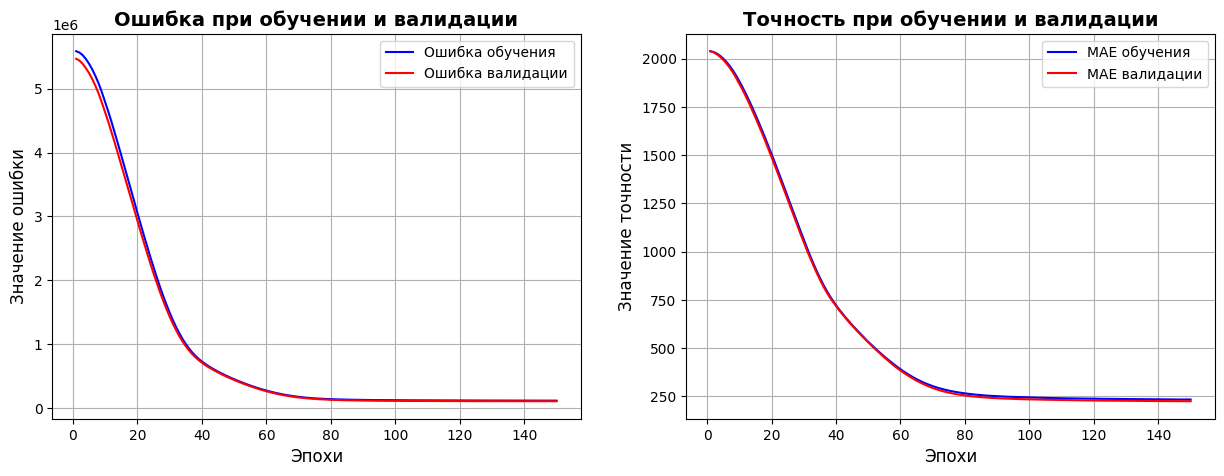

In [56]:
plot_training_curves(history2)

In [50]:
y_pred = model2.predict(X_test) # обучения модели на тестовом наборе

34/34 [==============================] - 0s 1ms/step


In [51]:
generate_preformance_scores(y_test, y_pred)

mse:	112661.6828
mae:	226.5433
r2:	0.9171


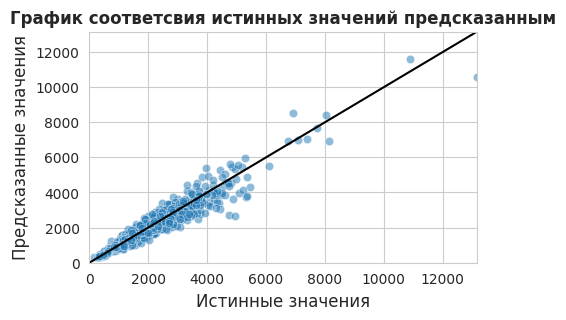

In [52]:
scatter_plot(y_test, y_pred)